In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output, Image
import csv

# Semi-classical one-dimensional Doppler cooling

Let's use a semi-classical framework to do a Quantum Monte Carlo calculation of Doppler cooling. We'll use the same setup as in the example by [Mølmer _et al._ ](https://www.osapublishing.org/josab/abstract.cfm?URI=josab-10-3-524) so that we can compare the performance. This will be semi-classical in the sense that the external state of the atom is classical, while the internal state is not. This dramatically reduces the basis size since we don't have to account for momentum states. The master's thesis by [Renauld Chrétien](https://orbi.uliege.be/handle/2268/212746) also contains some useful derivations.

We start out from the following Hamiltonian:
$$H = \frac{\hat{p}^2}{2m} + \hbar \Omega\cos(k \hat{x}) \left( |g\rangle\langle e| + |e\rangle\langle g| \right) - \hbar\delta|e\rangle\langle e|,$$
which is now understood to _only_ couple to the interal part of the wave function. 

We assume Na atoms, the relevant parameters are defined below:

In [2]:
m = 3.8175409E-26 #Sodium mass
hbar = 1.05457E-34
k = 2*np.pi/(589E-9)
Gamma = 200*hbar*k**2/m

Laser parameters: Rabi frequency and detuning:

In [3]:
Omega = Gamma/2
delta = -Gamma/2

Numerical parameters, such as step size:

In [4]:
dt = 1/(100*Gamma) #1/(1000*Gamma)
tend = 2000/Gamma
timeax = np.arange(0, tend, dt)
nsteps = len(timeax)

The function that we define here takes a step. This is similar to an Euler method for solving differential equations. In principle these methods are bad for solving Hamiltonians because they are not norm preserving (unless one takes very small steps). This doesn't matter so much, because the QMC method renormalizes the wave function after every step.

In the semi-classical case, we define the wave function as $|\psi\rangle = \alpha |g\rangle + \beta |e\rangle$ with classical position $x$ and momentum $p$. We measure momentum in recoil momenta ($\hbar k$) and position in meters. The prescription for an update looks like:
$$
    \begin{align}
    \alpha &\mapsto \alpha - i\,dt\left( \frac{\hbar (kp)^2}{2m}\alpha + \Omega \cos(kx)\beta \right) \\ 
    \beta &\mapsto \beta - i\,dt\left( \frac{\hbar (kp)^2}{2m}\beta + \Omega \cos(kx)\alpha - \delta\beta - \frac{i\Gamma\beta}{2} \right) \\
    p &\mapsto p + 2dt\,\Omega\sin(kx) \, \Re\left(\alpha \beta^*\right) \\
    x &\mapsto x + dt\frac{\hbar k p}{m}
    \end{align}
$$
Here we used the classical force $F = -\langle \psi | \nabla \mathcal{H} | \psi \rangle = 2\Omega\sin(kx) \, \Re\left(\alpha \beta^*\right)$ in order to get an expression for the change in momentum $p$. Note that the expression for $\beta$ has a term making the total Hamiltonian non-Hermitian. This is to simulate 'probability leaking out' of the excited state due to emission. 

In [5]:
def step(alpha, beta, p, x):
    alphaN = alpha - 1j * dt * (hbar*(k*p)**2/(2*m) * alpha + Omega * np.cos(k*x) * beta)
    betaN = beta - 1j * dt * (hbar*(k*p)**2/(2*m) * beta + Omega * np.cos(k*x) * alpha - delta*beta - 1j*Gamma*beta/2)
    pN = p + dt*Omega*np.sin(k*x) * 2*np.real(alpha * np.conj(beta))
    xN = x + dt*(hbar*k*p)/m

    return alphaN, betaN, pN, xN

Below we define the function that calculates one Monte Carlo trajectory. It returns the wave function coefficients of $|g\rangle$ and $|e\rangle$, and the atom its position and momentum. We initialize everything in the ground state, at $x=0$ and $p=0$. Then we draw random numbers to determine what will happen at every step (this is much faster than drawing a new number every step) and then we start stepping. The probability of decay is given by $dp = \beta\Gamma dt$.

If a jump happens we use the weighted probability as given by Mølmer _et al._ to determine whether there's a momentum kick in the $\pm z$ direction or whether there's no net momentum transfer. We add the initially absorbed photon to this, since that's not accounted for yet. 

If there's no jump we normalize the wavefunction by doing $\alpha \mapsto \alpha/\sqrt{1-dp}$ and $\beta \mapsto \beta/\sqrt{1-dp}$, since $dp$ is the probability that has 'leaked out' of the system.

In [6]:
def MCTrajectory():
    alphaO = 1.0
    betaO = 0.0
    pO = 0.0
    xO = 0.0

    alpha = np.zeros(len(timeax), dtype=complex)
    beta = np.zeros(len(timeax), dtype=complex)
    p = np.zeros(len(timeax))
    x = np.zeros(len(timeax))
    
    alpha[0] = alphaO
    beta[0] = betaO
    p[0] = pO
    x[0] = xO
    
    # Draw MC numbers
    rs = np.random.random(len(timeax))

    for i in range(1, len(timeax)):
        (alphaO, betaO, pO, xO) = step(alphaO, betaO, pO, xO)

        # Do we make a jump?
        dp = Gamma*dt*np.abs(betaO)**2
        r = rs[i]
        if r <= dp:
            # We make a jump: population back to |g> and give a random kick
            alphaO = betaO/np.abs(betaO)
            betaO = 0.0
            pO += random.choice([1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 2.0, -2.0])
        else:
            # We don't make a jump; renormalize the wave function
            alphaO = alphaO / np.sqrt(1 - dp)
            betaO = betaO / np.sqrt(1 - dp)

        alpha[i] = alphaO
        beta[i] = betaO
        p[i] = pO
        x[i] = xO
    return alpha, beta, p, x

Now we run a bunch of trajectories, this takes some time. 

In [7]:
ntraj = 1000

alphaPopAve = np.zeros(len(timeax))
betaPopAve = np.zeros(len(timeax))
pSqAve = np.zeros(len(timeax))
xAve = np.zeros(len(timeax))

for i in range(ntraj):
    (alphaSim, betaSim, pSim, xSim) = MCTrajectory()
    alphaPopAve += np.abs(alphaSim)**2 / ntraj
    betaPopAve += np.abs(betaSim)**2 / ntraj
    pSqAve += pSim**2 / ntraj
    xAve += xSim / ntraj

    clear_output()
    print(i)
clear_output()

Export the expectation values:

In [8]:
filename = 'semiclassical-doppler-cooling.csv'
data = np.transpose([timeax, alphaPopAve, betaPopAve, pSqAve, xAve])
with open(filename, 'w') as file:
    writer = csv.writer(file, delimiter=',')
    writer.writerow(['time', 'alpha', 'beta', 'p^2', 'x'])
    for row in data:
        writer.writerow(row)

Let's plot the excpectation value $\langle p^2 \rangle$. We compare it to the fully quantized calculation as well.

In [9]:
filename = 'qmc_1d_doppler.csv'
quantDat = np.genfromtxt(filename, delimiter = ',')

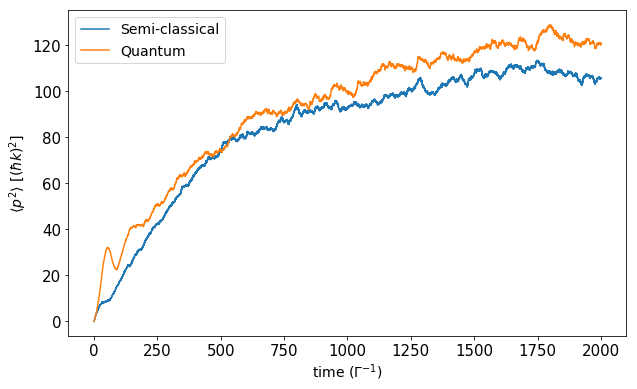

In [10]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(Gamma*timeax, pSqAve)
ax.plot(quantDat[:, 0], quantDat[:, 1])
plt.xlabel(r'time ($\Gamma^{-1}$)', fontsize=14)
plt.ylabel(r'$\langle p^2 \rangle$ [$\left(\hbar k\right)^2$]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize = 15)
ax.legend(['Semi-classical', 'Quantum'], fontsize = 14)
plt.show()

The quantum calculation is the same as that by Mölmer _et al._:

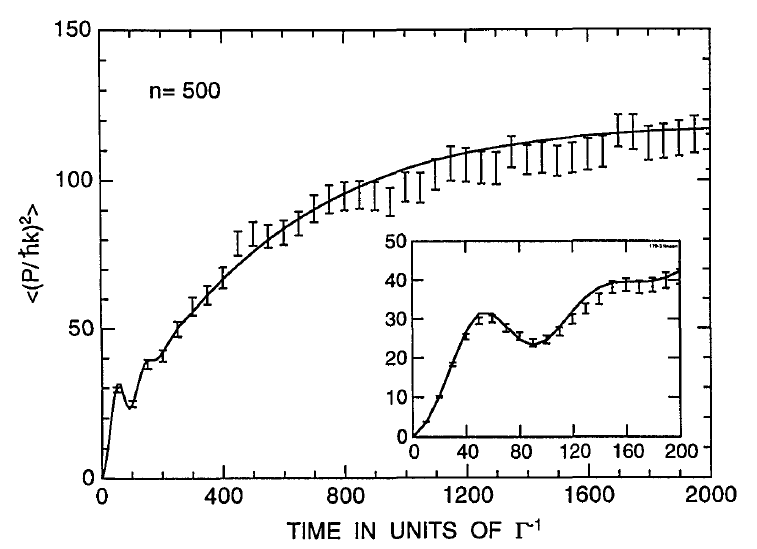

In [2]:
Image('molmer-1d-doppler.png')